In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

sns.set(style="whitegrid")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load raw data to match final pipeline
DATA_PATH = "../data/raw/synthetic_coffee_health_10000.csv"
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)

# Fill missing values like 09
df.fillna({
    'Gender': df['Gender'].mode()[0],
    'Country': df['Country'].mode()[0],
    'Sleep_Quality': df['Sleep_Quality'].mode()[0],
    'Occupation': df['Occupation'].mode()[0],
    'Smoking': df['Smoking'].mode()[0],
    'Alcohol_Consumption': df['Alcohol_Consumption'].mode()[0]
}, inplace=True)

# Encode categorical columns (including Stress_Level)
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Occupation', 'Smoking', 'Alcohol_Consumption', 'Stress_Level']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# BMI category and drop ID
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0,18.5,24.9,29.9,100], labels=['Underweight','Normal','Overweight','Obese'])
df['BMI_Category'] = LabelEncoder().fit_transform(df['BMI_Category'])
df.drop(['ID'], axis=1, inplace=True, errors='ignore')

# Separate features and target, sanitize
df = df.dropna(subset=['Health_Issues']).copy()
X_df = df.drop(columns=["Health_Issues"]).replace([np.inf, -np.inf], np.nan).fillna(0)
feature_names = list(X_df.columns)
y = df["Health_Issues"]

# Scale like 09
scaler = joblib.load("../outputs/models/scaler.pkl")
X = scaler.transform(X_df)
X_scaled_df = pd.DataFrame(X, columns=feature_names)

Data shape: (10010, 16)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
MODEL_PATH = "../outputs/models/final_health_risk_model.pkl"
model = joblib.load(MODEL_PATH)
print("Model loaded successfully.")


Model loaded successfully.


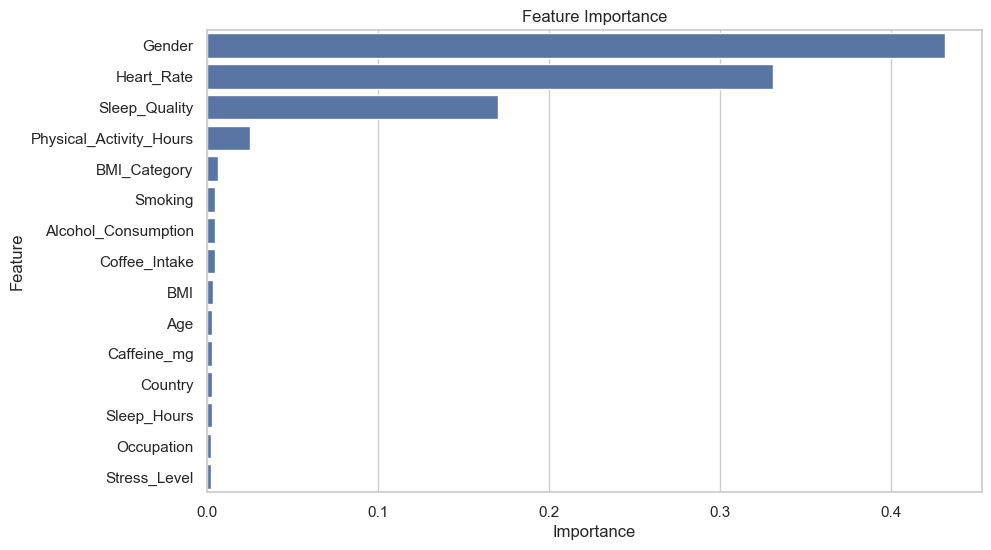

In [4]:
if hasattr(model, "feature_importances_"):
    feature_importances = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(data=feature_importances, x="Importance", y="Feature")
    plt.title("Feature Importance")
    plt.show()
else:
    print("Model does not have feature_importances_ attribute.")


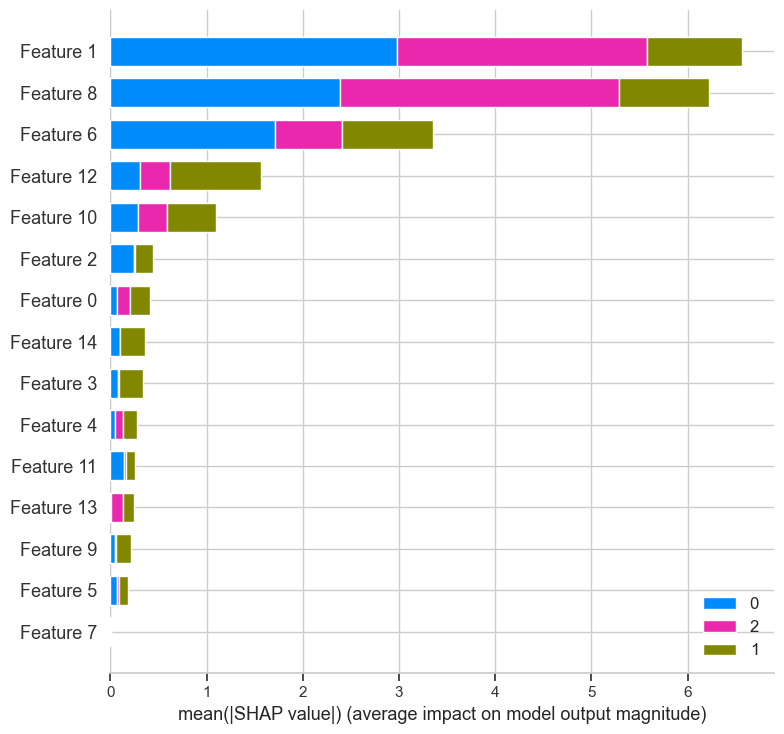

<Figure size 640x480 with 0 Axes>

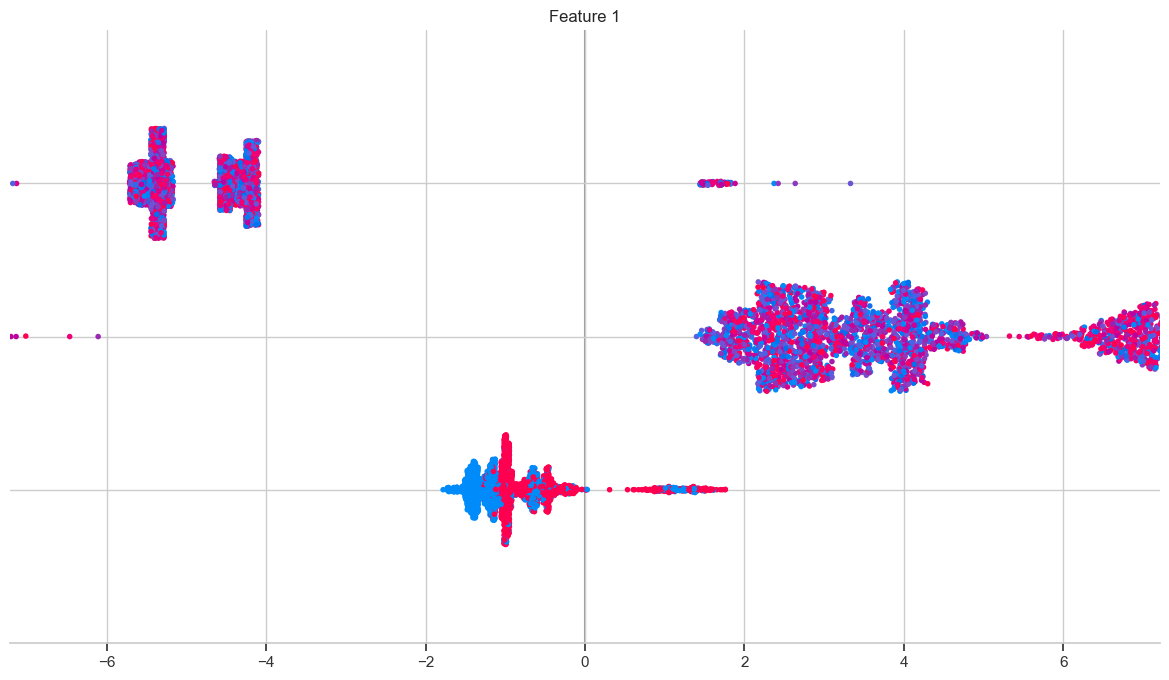

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar", class_names=model.classes_)

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, X, class_names=model.classes_)

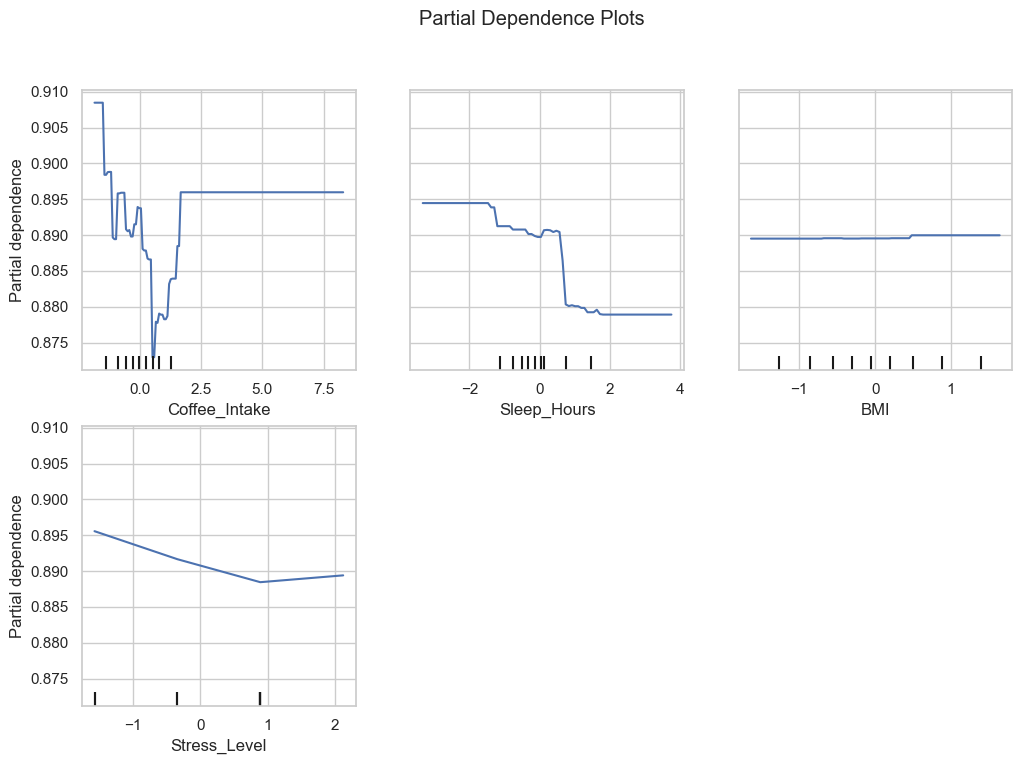

In [6]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ["Coffee_Intake", "Sleep_Hours", "BMI", "Stress_Level"]
# Map feature names to indices for the scaled array
feat_indices = [feature_names.index(f) for f in features_to_plot if f in feature_names]
fig, ax = plt.subplots(figsize=(12,8))
PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=feat_indices,
    feature_names=feature_names,
    target=model.classes_[0],  # specify a class for multi-class
    ax=ax,
)
plt.suptitle("Partial Dependence Plots")
plt.show()

In [7]:
sample_idx = 0
try:
    # Handle multiclass shap values format
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        sv[sample_idx, :],
        X_scaled_df.iloc[sample_idx, :],
        matplotlib=True,
    )
except Exception as e:
    print(f"Skipping force_plot due to: {e}")

Skipping force_plot due to: matplotlib = True is not yet supported for force plots with multiple samples!
